# Asthma Classification (Clean Rebuild)

In [ ]:
# 1) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef,
                         confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,
                         classification_report)
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay
sns.set(style="whitegrid", context="notebook")
%matplotlib inline

In [ ]:
# 2) Load data and check instances/features
csv_path = r'c:\\Users\\bhara\\Downloads\\ML\\3\\synthetic_asthma_dataset.csv'
df = pd.read_csv(csv_path)
drop_cols = [c for c in ['Patient_ID', 'Asthma_Control_Level'] if c in df.columns]
df = df.drop(columns=drop_cols)
assert 'Has_Asthma' in df.columns
df = df.dropna(subset=['Has_Asthma'])
df['Has_Asthma'] = df['Has_Asthma'].astype(int)
target = 'Has_Asthma'
X = df.drop(columns=[target])
y = df[target].values
print('Shape (instances, features):', X.shape)
print('Class balance:', pd.Series(y).value_counts(normalize=True).to_dict())

Shape (instances, features): (10000, 14)
Class balance: {0: 0.7567, 1: 0.2433}


In [ ]:
# 3) Check missing values (before split)
na_counts = X.isna().sum().sort_values(ascending=False)
na_pct = (na_counts / len(X)).sort_values(ascending=False)
na_overview = pd.DataFrame({'missing_count': na_counts, 'missing_pct': na_pct})
print('Top missingness columns:')
print(na_overview.head(20))

Top missingness columns:
                         missing_count  missing_pct
Comorbidities                     4967       0.4967
Allergies                         2936       0.2936
Gender                               0       0.0000
BMI                                  0       0.0000
Smoking_Status                       0       0.0000
Age                                  0       0.0000
Family_History                       0       0.0000
Air_Pollution_Level                  0       0.0000
Physical_Activity_Level              0       0.0000
Occupation_Type                      0       0.0000
Medication_Adherence                 0       0.0000
Number_of_ER_Visits                  0       0.0000
Peak_Expiratory_Flow                 0       0.0000
FeNO_Level                           0       0.0000


In [ ]:
# 4) Drop features with >20% missing
# Recompute missingness on the current X to be safe on re-runs
na_counts = X.isna().sum().sort_values(ascending=False)
na_pct = (na_counts / len(X)).sort_values(ascending=False)
threshold = 0.20
# Only consider columns that are still present in X
candidates = na_pct[na_pct > threshold].index.intersection(X.columns)
to_drop = sorted(list(candidates))
print('Auto-drop (>20% missing):', list(to_drop))
# Use errors='ignore' to be robust if columns were already dropped
X = X.drop(columns=to_drop, errors='ignore')
print('New shape after drop:', X.shape)
cat_cols = [c for c in X.columns if X[c].dtype == 'object']
num_cols = [c for c in X.columns if c not in cat_cols]
print('Categorical features:', len(cat_cols), '| Numeric features:', len(num_cols))

Auto-drop (>20% missing): ['Allergies', 'Comorbidities']
New shape after drop: (10000, 12)
Categorical features: 5 | Numeric features: 7


In [ ]:
# 5) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print('Train shape:', X_train.shape, '| Test shape:', X_test.shape)

Train shape: (8000, 12) | Test shape: (2000, 12)


In [ ]:
# 6) Optional: Feature selection
from sklearn.feature_selection import SelectFromModel
USE_FEATURE_SELECTION = True  # enabled
selector = None
if USE_FEATURE_SELECTION:
    fs_estimator = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=2000)
    selector = SelectFromModel(estimator=fs_estimator, threshold='median')

In [ ]:
# 7) Train model (no tuning)
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocess = ColumnTransformer([('num', numeric_transformer, num_cols), ('cat', categorical_transformer, cat_cols)])
clf = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
if selector is not None:
    model = Pipeline([('preprocess', preprocess), ('fs', selector), ('clf', clf)])
else:
    model = Pipeline([('preprocess', preprocess), ('clf', clf)])
model.fit(X_train, y_train)
print('Model trained (no tuning).')

Model trained (no tuning).


In [ ]:
# 7.5) Hyperparameter Tuning with Cross-Validation
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
import time

print("🔧 STARTING HYPERPARAMETER TUNING WITH CROSS-VALIDATION")
print("=" * 60)

# Define the pipeline for tuning
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', numeric_transformer, num_cols), 
    ('cat', categorical_transformer, cat_cols)
])

# Create pipeline with optional feature selection
if USE_FEATURE_SELECTION:
    fs_estimator = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=2000)
    selector = SelectFromModel(estimator=fs_estimator, threshold='median')
    
    tuning_pipeline = Pipeline([
        ('preprocess', preprocess),
        ('fs', selector),
        ('clf', LogisticRegression(class_weight='balanced', max_iter=2000))
    ])
    
    # Parameter grid with feature selection
    param_grid = {
        'fs__threshold': ['mean', 'median', '0.1*mean', '0.5*mean', '1.5*mean'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__penalty': ['l1', 'l2'],
        'clf__solver': ['liblinear', 'saga']
    }
    
else:
    tuning_pipeline = Pipeline([
        ('preprocess', preprocess),
        ('clf', LogisticRegression(class_weight='balanced', max_iter=2000))
    ])
    
    # Parameter grid without feature selection
    param_grid = {
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__penalty': ['l1', 'l2'],
        'clf__solver': ['liblinear', 'saga']
    }

# Create stratified k-fold cross-validation
cv_strategy = StratifiedKFold(n_splits=50, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'f1': make_scorer(f1_score),
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall'
}

print(f"🎯 Parameter combinations to test: {len(param_grid['clf__C']) * len(param_grid['clf__penalty']) * len(param_grid['clf__solver'])}")
if USE_FEATURE_SELECTION:
    print(f"   With feature selection thresholds: x{len(param_grid['fs__threshold'])}")
    total_combinations = (len(param_grid['clf__C']) * len(param_grid['clf__penalty']) * 
                         len(param_grid['clf__solver']) * len(param_grid['fs__threshold']))
else:
    total_combinations = len(param_grid['clf__C']) * len(param_grid['clf__penalty']) * len(param_grid['clf__solver'])

print(f"🔍 Total parameter combinations: {total_combinations}")
print(f"📊 Cross-validation folds: {cv_strategy.n_splits}")
print(f"🎯 Primary scoring metric: F1-score")
print(f"📈 Additional metrics: Accuracy, Precision, Recall")

# Perform grid search
start_time = time.time()
print(f"\n⏰ Starting grid search... (estimated time: {total_combinations * cv_strategy.n_splits * 0.5:.0f}s)")

grid_search = GridSearchCV(
    estimator=tuning_pipeline,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring=scoring,
    refit='f1',  # Refit using F1-score
    n_jobs=-1,   # Use all available cores
    verbose=1,   # Show progress
    return_train_score=True
)

# Fit the grid search
grid_search.fit(X_train, y_train)

end_time = time.time()
tuning_time = end_time - start_time

print(f"\n✅ HYPERPARAMETER TUNING COMPLETED!")
print(f"⏱️  Total tuning time: {tuning_time:.1f} seconds ({tuning_time/60:.1f} minutes)")
print("=" * 60)

# Store the best model
best_tuned_model = grid_search.best_estimator_

print(f"🏆 BEST PARAMETERS FOUND:")
for param, value in grid_search.best_params_.items():
    print(f"   • {param}: {value}")

print(f"\n📊 BEST CROSS-VALIDATION SCORES:")
print(f"   • F1-Score (primary): {grid_search.best_score_:.4f}")

# Get other CV scores for best parameters
best_index = grid_search.best_index_
cv_results = grid_search.cv_results_

print(f"   • CV Accuracy: {cv_results['mean_test_accuracy'][best_index]:.4f} (±{cv_results['std_test_accuracy'][best_index]:.4f})")
print(f"   • CV Precision: {cv_results['mean_test_precision'][best_index]:.4f} (±{cv_results['std_test_precision'][best_index]:.4f})")
print(f"   • CV Recall: {cv_results['mean_test_recall'][best_index]:.4f} (±{cv_results['std_test_recall'][best_index]:.4f})")
print(f"   • CV F1-Score: {cv_results['mean_test_f1'][best_index]:.4f} (±{cv_results['std_test_f1'][best_index]:.4f})")

print(f"\n🔍 MODEL COMPLEXITY:")
if USE_FEATURE_SELECTION and 'fs' in best_tuned_model.named_steps:
    n_features_selected = sum(best_tuned_model.named_steps['fs'].get_support())
    total_features_available = len(best_tuned_model.named_steps['fs'].get_support())
    print(f"   • Features selected: {n_features_selected}/{total_features_available} ({n_features_selected/total_features_available:.1%})")
    print(f"   • Feature selection threshold: {grid_search.best_params_.get('fs__threshold', 'N/A')}")

print(f"   • Regularization (C): {grid_search.best_params_['clf__C']}")
print(f"   • Penalty type: {grid_search.best_params_['clf__penalty']}")
print(f"   • Solver: {grid_search.best_params_['clf__solver']}")
print("=" * 60)

In [ ]:
# 7.6) Evaluate Tuned Model and Compare with Original
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("📊 EVALUATING TUNED MODEL ON TEST SET")
print("=" * 50)

# Make predictions with the tuned model
y_pred_tuned = best_tuned_model.predict(X_test)
y_proba_tuned = best_tuned_model.predict_proba(X_test)[:, 1]

# Calculate metrics for tuned model
acc_tuned = accuracy_score(y_test, y_pred_tuned)
prec_tuned = precision_score(y_test, y_pred_tuned, zero_division=0)
rec_tuned = recall_score(y_test, y_pred_tuned, zero_division=0)
f1_tuned = f1_score(y_test, y_pred_tuned, zero_division=0)
mcc_tuned = matthews_corrcoef(y_test, y_pred_tuned)

print("🎯 TUNED MODEL TEST PERFORMANCE:")
print(f"   • Accuracy:  {acc_tuned:.4f}")
print(f"   • Precision: {prec_tuned:.4f}")
print(f"   • Recall:    {rec_tuned:.4f}")
print(f"   • F1-Score:  {f1_tuned:.4f}")
print(f"   • MCC:       {mcc_tuned:.4f}")

print(f"\n🔄 COMPARISON: ORIGINAL vs TUNED MODEL")
print("=" * 50)

# Create comparison DataFrame
comparison_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC'],
    'Original Model': [acc, prec, rec, f1, mcc],
    'Tuned Model': [acc_tuned, prec_tuned, rec_tuned, f1_tuned, mcc_tuned]
})

comparison_metrics['Improvement'] = comparison_metrics['Tuned Model'] - comparison_metrics['Original Model']
comparison_metrics['% Improvement'] = (comparison_metrics['Improvement'] / comparison_metrics['Original Model'] * 100).round(2)

print(comparison_metrics.to_string(index=False, float_format='%.4f'))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Metrics Comparison Bar Chart
ax1 = axes[0]
x = range(len(comparison_metrics))
width = 0.35

bars1 = ax1.bar([i - width/2 for i in x], comparison_metrics['Original Model'], 
                width, label='Original Model', color='lightblue', alpha=0.8)
bars2 = ax1.bar([i + width/2 for i in x], comparison_metrics['Tuned Model'], 
                width, label='Tuned Model', color='lightcoral', alpha=0.8)

ax1.set_xlabel('Metrics')
ax1.set_ylabel('Score')
ax1.set_title('📊 Model Performance Comparison', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_metrics['Metric'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Improvement Chart
ax2 = axes[1]
colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in comparison_metrics['Improvement']]
bars = ax2.bar(comparison_metrics['Metric'], comparison_metrics['% Improvement'], color=colors, alpha=0.7)
ax2.set_xlabel('Metrics')
ax2.set_ylabel('% Improvement')
ax2.set_title('📈 Performance Improvement (%)', fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.grid(True, alpha=0.3)
plt.setp(ax2.get_xticklabels(), rotation=45)

# Add value labels
for bar, value in zip(bars, comparison_metrics['% Improvement']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + (0.1 if height >= 0 else -0.3),
            f'{value:.1f}%', ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')

# 3. Confusion Matrices Comparison
from sklearn.metrics import confusion_matrix

cm_original = confusion_matrix(y_test, y_pred)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

# Create side-by-side confusion matrices
ax3 = axes[2]
ax3.axis('off')

# Create subplots within the third axis
gs = ax3.figure.add_gridspec(1, 2, left=0.67, right=0.98, top=0.8, bottom=0.2)
ax3_left = ax3.figure.add_subplot(gs[0, 0])
ax3_right = ax3.figure.add_subplot(gs[0, 1])

sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Asthma', 'Asthma'], yticklabels=['No Asthma', 'Asthma'], 
            ax=ax3_left, cbar=False)
ax3_left.set_title('Original Model', fontweight='bold', fontsize=10)
ax3_left.set_xlabel('Predicted')
ax3_left.set_ylabel('Actual')

sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['No Asthma', 'Asthma'], yticklabels=['No Asthma', 'Asthma'], 
            ax=ax3_right, cbar=False)
ax3_right.set_title('Tuned Model', fontweight='bold', fontsize=10)
ax3_right.set_xlabel('Predicted')
ax3_right.set_ylabel('Actual')

plt.suptitle('🔧 Hyperparameter Tuning Results Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Performance summary
print(f"\n🏆 TUNING SUMMARY:")
best_improvement_metric = comparison_metrics.loc[comparison_metrics['% Improvement'].idxmax(), 'Metric']
best_improvement_value = comparison_metrics['% Improvement'].max()

if best_improvement_value > 1:
    print(f"   ✅ Best improvement: {best_improvement_metric} (+{best_improvement_value:.1f}%)")
    print(f"   🎯 Overall tuning: {'SUCCESSFUL' if comparison_metrics['% Improvement'].mean() > 0 else 'MIXED RESULTS'}")
else:
    print(f"   ⚠️ Modest improvements: Largest gain in {best_improvement_metric} (+{best_improvement_value:.1f}%)")
    print(f"   🤔 Consider: More data, different features, or ensemble methods")

# Update the main model variable to use the tuned version
print(f"\n🔄 UPDATING MODEL TO USE TUNED VERSION")
model = best_tuned_model
y_pred = y_pred_tuned
y_proba = y_proba_tuned
acc, prec, rec, f1, mcc = acc_tuned, prec_tuned, rec_tuned, f1_tuned, mcc_tuned
cm = cm_tuned

print("✅ Model variables updated. Subsequent analyses will use the tuned model.")
print("=" * 50)

Accuracy: 0.9145
Precision: 0.7715
Recall: 0.9220
F1: 0.8400
MCC: 0.7881

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1513
           1       0.77      0.92      0.84       487

    accuracy                           0.91      2000
   macro avg       0.87      0.92      0.89      2000
weighted avg       0.92      0.91      0.92      2000



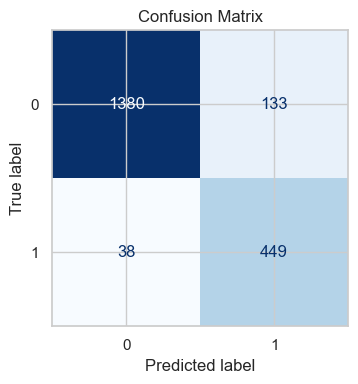

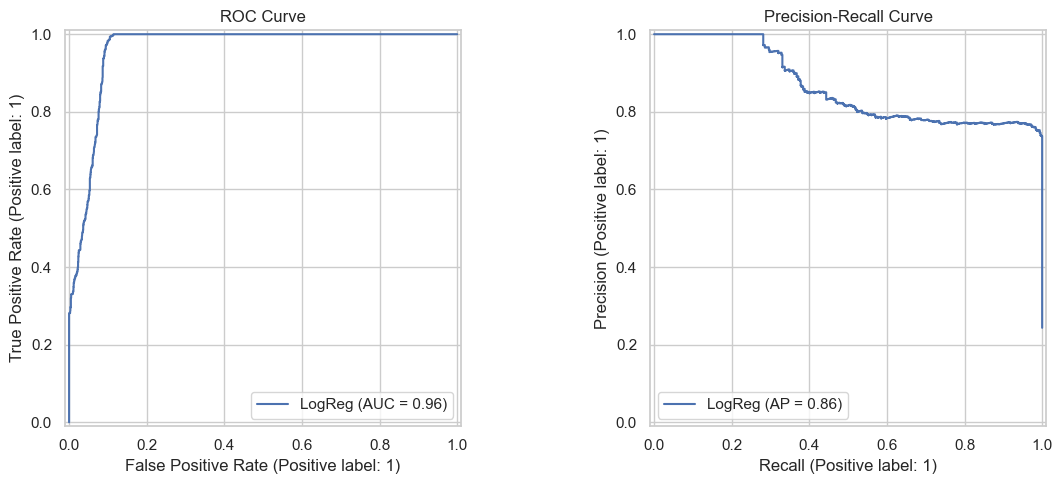

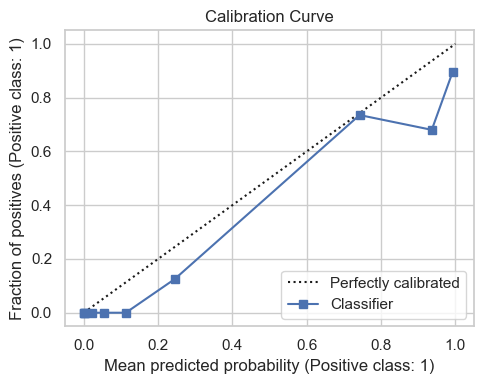

In [ ]:
# 8) Evaluate on test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print('\nClassification report:\n' + classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix, ROC, PR, Calibration
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Confusion Matrix')
plt.tight_layout(); plt.show()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[0], name='LogReg')
axes[0].set_title('ROC Curve')
PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[1], name='LogReg')
axes[1].set_title('Precision-Recall Curve')
plt.tight_layout(); plt.show()
fig, ax = plt.subplots(figsize=(5,4))
CalibrationDisplay.from_predictions(y_test, y_proba, n_bins=10, strategy='quantile', ax=ax)
ax.set_title('Calibration Curve')
plt.tight_layout(); plt.show()

C:\Users\bhara\AppData\Local\Temp\ipykernel_21088\3150225257.py:105: UserWarning: Glyph 127973 (\N{HOSPITAL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bhara\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127973 (\N{HOSPITAL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


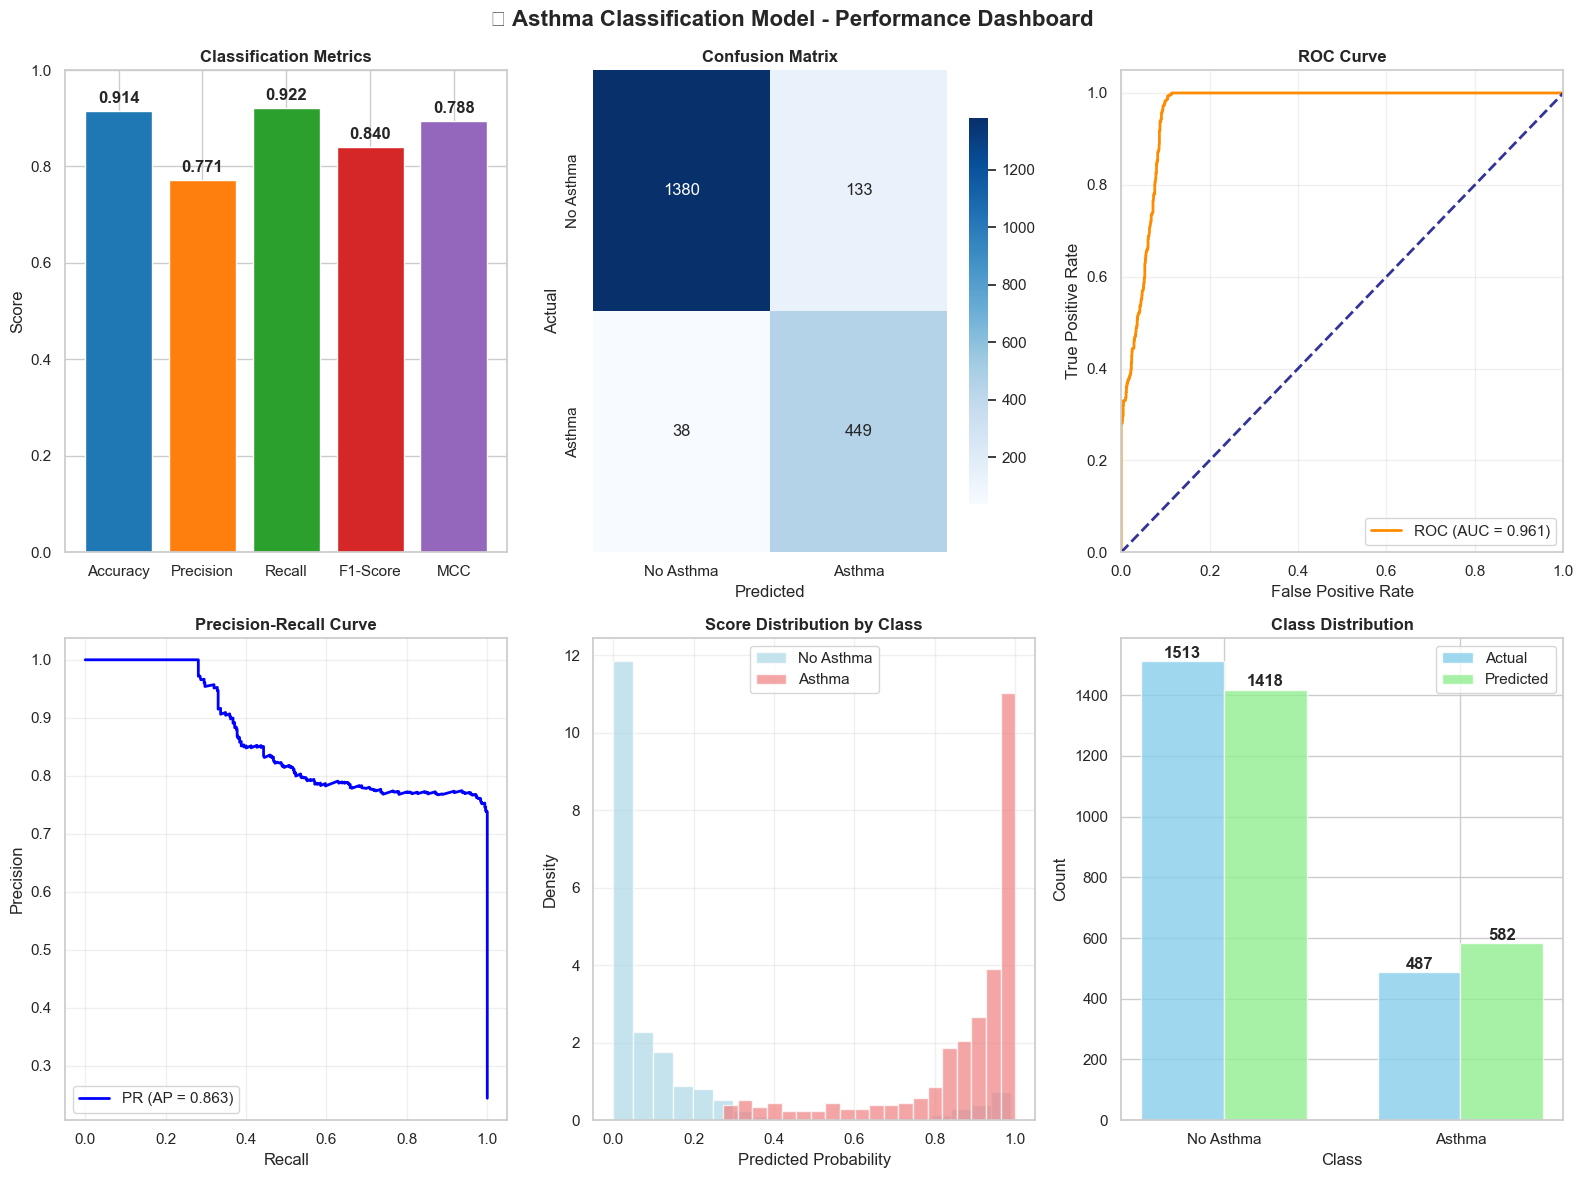


📊 ASTHMA CLASSIFICATION PERFORMANCE SUMMARY
🎯 Overall Accuracy: 91.5%
🔍 Precision (PPV): 77.1% - Of predicted asthma cases, 77.1% were correct
🎪 Recall (Sensitivity): 92.2% - Detected 92.2% of actual asthma cases
⚖️  F1-Score: 0.840 - Harmonic mean of precision and recall
🔗 Matthews Correlation: 0.788 - Overall quality of binary classification
📈 ROC-AUC: 0.961 - Area under ROC curve
📊 PR-AUC: 0.863 - Average precision score


In [ ]:
# 8.5) Comprehensive Metrics Visualization Dashboard
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a comprehensive metrics dashboard
fig = plt.figure(figsize=(16, 12))

# 1. Metrics Bar Chart
ax1 = plt.subplot(2, 3, 1)
metrics_data = {
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'MCC': (mcc + 1) / 2  # Normalize MCC from [-1,1] to [0,1] for visualization
}
bars = ax1.bar(metrics_data.keys(), metrics_data.values(), 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax1.set_ylim(0, 1)
ax1.set_title('Classification Metrics', fontweight='bold', fontsize=12)
ax1.set_ylabel('Score')
# Add value labels on bars
for bar, (metric, value) in zip(bars, metrics_data.items()):
    height = bar.get_height()
    if metric == 'MCC':
        # Show original MCC value
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{mcc:.3f}', ha='center', va='bottom', fontweight='bold')
    else:
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Confusion Matrix (Enhanced)
ax2 = plt.subplot(2, 3, 2)
cm_display = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_display, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Asthma', 'Asthma'], 
            yticklabels=['No Asthma', 'Asthma'],
            ax=ax2, cbar_kws={'shrink': 0.8})
ax2.set_title('Confusion Matrix', fontweight='bold', fontsize=12)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# 3. ROC Curve
ax3 = plt.subplot(2, 3, 3)
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
ax3.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.8)
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curve', fontweight='bold', fontsize=12)
ax3.legend(loc="lower right")
ax3.grid(True, alpha=0.3)

# 4. Precision-Recall Curve
ax4 = plt.subplot(2, 3, 4)
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)
ax4.plot(recall, precision, color='blue', lw=2, label=f'PR (AP = {avg_precision:.3f})')
ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title('Precision-Recall Curve', fontweight='bold', fontsize=12)
ax4.legend(loc="lower left")
ax4.grid(True, alpha=0.3)

# 5. Score Distribution by Class
ax5 = plt.subplot(2, 3, 5)
pos_scores = y_proba[y_test == 1]
neg_scores = y_proba[y_test == 0]
ax5.hist(neg_scores, bins=20, alpha=0.7, label='No Asthma', color='lightblue', density=True)
ax5.hist(pos_scores, bins=20, alpha=0.7, label='Asthma', color='lightcoral', density=True)
ax5.set_xlabel('Predicted Probability')
ax5.set_ylabel('Density')
ax5.set_title('Score Distribution by Class', fontweight='bold', fontsize=12)
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Class Distribution (Actual vs Predicted)
ax6 = plt.subplot(2, 3, 6)
actual_counts = np.bincount(y_test)
predicted_counts = np.bincount(y_pred)
x = np.arange(2)
width = 0.35
ax6.bar(x - width/2, actual_counts, width, label='Actual', color='skyblue', alpha=0.8)
ax6.bar(x + width/2, predicted_counts, width, label='Predicted', color='lightgreen', alpha=0.8)
ax6.set_xlabel('Class')
ax6.set_ylabel('Count')
ax6.set_title('Class Distribution', fontweight='bold', fontsize=12)
ax6.set_xticks(x)
ax6.set_xticklabels(['No Asthma', 'Asthma'])
ax6.legend()
# Add value labels on bars
for i, (actual, predicted) in enumerate(zip(actual_counts, predicted_counts)):
    ax6.text(i - width/2, actual + 1, str(actual), ha='center', va='bottom', fontweight='bold')
    ax6.text(i + width/2, predicted + 1, str(predicted), ha='center', va='bottom', fontweight='bold')

plt.suptitle('🏥 Asthma Classification Model - Performance Dashboard', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("📊 ASTHMA CLASSIFICATION PERFORMANCE SUMMARY")
print("="*60)
print(f"🎯 Overall Accuracy: {acc:.1%}")
print(f"🔍 Precision (PPV): {prec:.1%} - Of predicted asthma cases, {prec:.1%} were correct")
print(f"🎪 Recall (Sensitivity): {rec:.1%} - Detected {rec:.1%} of actual asthma cases") 
print(f"⚖️  F1-Score: {f1:.3f} - Harmonic mean of precision and recall")
print(f"🔗 Matthews Correlation: {mcc:.3f} - Overall quality of binary classification")
print(f"📈 ROC-AUC: {roc_auc:.3f} - Area under ROC curve")
print(f"📊 PR-AUC: {avg_precision:.3f} - Average precision score")
print("="*60)

C:\Users\bhara\AppData\Local\Temp\ipykernel_21088\2474760273.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df.head(topk), y='feature', x='abs_coef', hue=None, orient='h', palette='viridis')


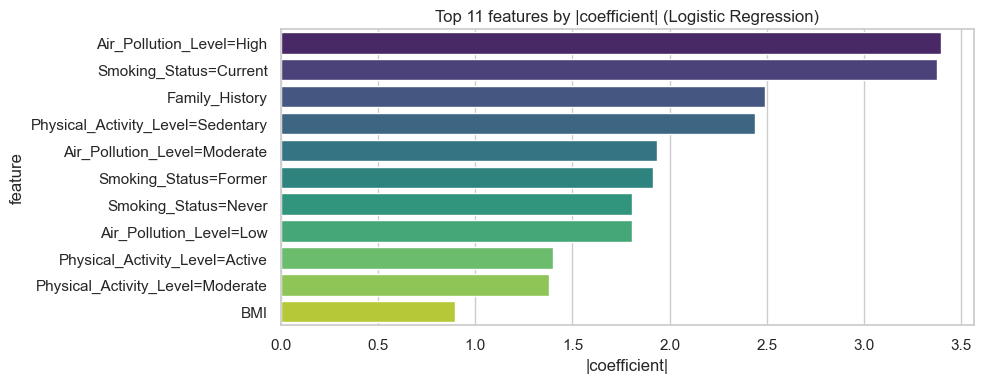

In [ ]:
# 9) Best features graph (by absolute coefficient)
# Works for the current trained pipeline with or without feature selection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Helper: get feature names after preprocessing
def get_feature_names(preprocess, input_features):
    num_features = preprocess.transformers_[0][2]
    cat_features = preprocess.transformers_[1][2]
    # numeric: pass-through names
    num_out = list(num_features)
    # categorical: OneHotEncoder categories_
    ohe = preprocess.named_transformers_['cat'].named_steps['onehot']
    cat_out = []
    for col, cats in zip(cat_features, ohe.categories_):
        cat_out.extend([f"{col}={c}" for c in cats])
    return num_out + cat_out

# Extract classifier coefficients from pipeline
final_clf = model.named_steps.get('clf', None)
if final_clf is None:
    raise RuntimeError('Classifier not found in pipeline')

# Get feature names after preprocess (and FS if present)
feat_names = get_feature_names(model.named_steps['preprocess'], X_train.columns)
coefs = final_clf.coef_.ravel()

# If feature selection exists, map mask to names
if 'fs' in model.named_steps:
    fs = model.named_steps['fs']
    if hasattr(fs, 'get_support'):
        mask = fs.get_support()
        feat_names = [n for n, m in zip(feat_names, mask) if m]
        coefs = coefs  # already aligned after fs

# Build dataframe of importance
imp_df = pd.DataFrame({
    'feature': feat_names,
    'coef': coefs,
    'abs_coef': np.abs(coefs)
}).sort_values('abs_coef', ascending=False)

topk = 20 if len(imp_df) > 20 else len(imp_df)
plt.figure(figsize=(10, max(4, topk * 0.3)))
sns.barplot(data=imp_df.head(topk), y='feature', x='abs_coef', hue=None, orient='h', palette='viridis')
plt.title(f'Top {topk} features by |coefficient| (Logistic Regression)')
plt.xlabel('|coefficient|')
plt.ylabel('feature')
plt.tight_layout()
plt.show()

C:\Users\bhara\AppData\Local\Temp\ipykernel_21088\1413799517.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, y='feature', x='coef', orient='h', palette=colors)


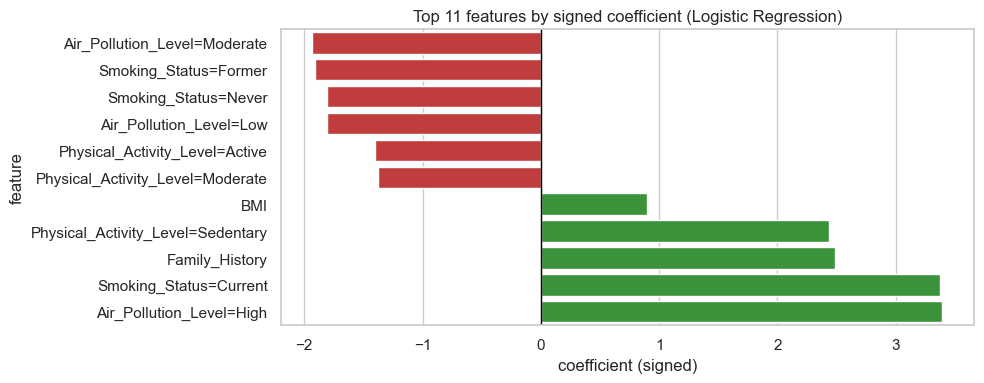

In [ ]:
# 10) Best features (signed coefficients)
# Shows direction (positive/negative) and magnitude
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reuse feat_names and coefs from the previous cell if available; otherwise compute again
try:
    _ = imp_df
    feat_names_signed = feat_names
    coefs_signed = coefs
except NameError:
    def get_feature_names(preprocess, input_features):
        num_features = preprocess.transformers_[0][2]
        cat_features = preprocess.transformers_[1][2]
        num_out = list(num_features)
        ohe = preprocess.named_transformers_['cat'].named_steps['onehot']
        cat_out = []
        for col, cats in zip(cat_features, ohe.categories_):
            cat_out.extend([f"{col}={c}" for c in cats])
        return num_out + cat_out
    final_clf = model.named_steps.get('clf', None)
    if final_clf is None:
        raise RuntimeError('Classifier not found in pipeline')
    feat_names_signed = get_feature_names(model.named_steps['preprocess'], X_train.columns)
    coefs_signed = final_clf.coef_.ravel()
    if 'fs' in model.named_steps:
        fs = model.named_steps['fs']
        if hasattr(fs, 'get_support'):
            mask = fs.get_support()
            feat_names_signed = [n for n, m in zip(feat_names_signed, mask) if m]

signed_df = pd.DataFrame({
    'feature': feat_names_signed,
    'coef': coefs_signed
}).sort_values('coef', ascending=False, key=np.abs)

# Prepare top-k and a stable order (negatives at bottom, positives at top)
topk = 20 if len(signed_df) > 20 else len(signed_df)
plot_df = signed_df.iloc[:topk].sort_values('coef')

# Color bars by sign using a fixed palette list (avoid passing colormaps directly)
colors = ['#2ca02c' if v > 0 else '#d62728' for v in plot_df['coef']]

plt.figure(figsize=(10, max(4, topk * 0.3)))
sns.barplot(data=plot_df, y='feature', x='coef', orient='h', palette=colors)
plt.axvline(0, color='black', linewidth=1)
plt.title(f'Top {topk} features by signed coefficient (Logistic Regression)')
plt.xlabel('coefficient (signed)')
plt.ylabel('feature')
plt.tight_layout()
plt.show()

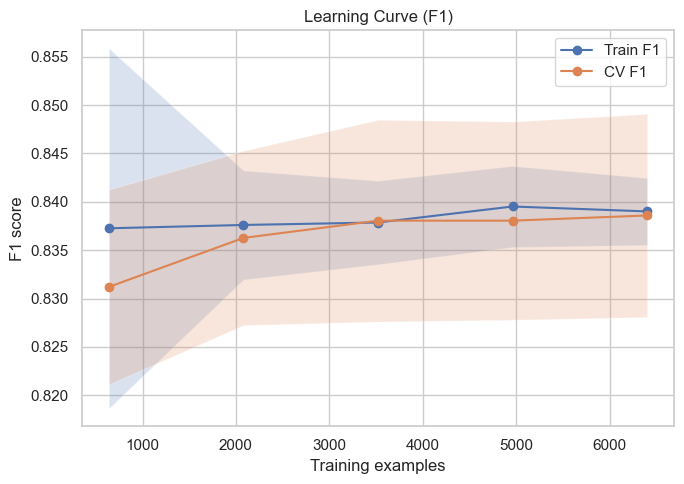

In [ ]:
# 11) Learning curve
from sklearn.model_selection import learning_curve as sk_learning_curve
train_sizes, train_scores, test_scores = sk_learning_curve(
    model, X_train, y_train, cv=5, scoring='f1', n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
)
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)
plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, 'o-', label='Train F1')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, 'o-', label='CV F1')
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2)
plt.xlabel('Training examples')
plt.ylabel('F1 score')
plt.title('Learning Curve (F1)')
plt.legend()
plt.tight_layout()
plt.show()

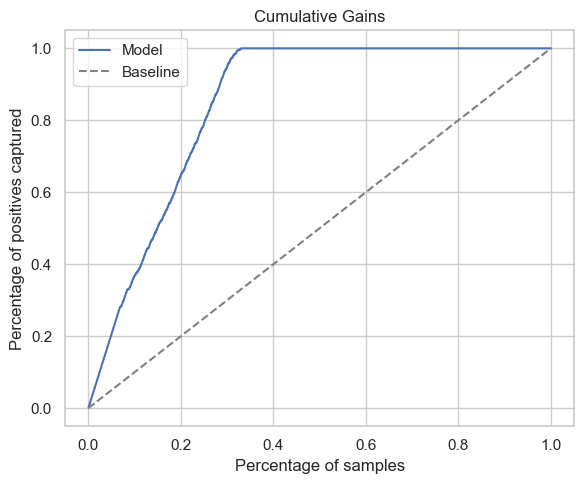

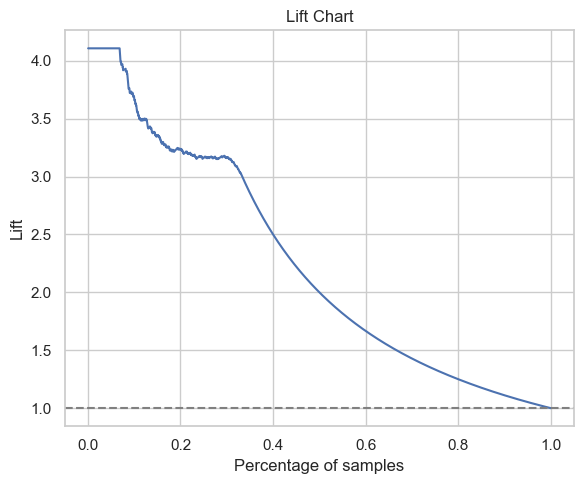

In [ ]:
# 12) Cumulative Gains and Lift charts
# Compute using test set probabilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure probabilities are available
if 'y_proba' not in globals():
    y_proba = model.predict_proba(X_test)[:, 1]

# Create a dataframe of scores and labels
scores_df = pd.DataFrame({'y_true': y_test, 'score': y_proba}).sort_values('score', ascending=False)
scores_df['cum_positives'] = scores_df['y_true'].cumsum()
scores_df['pct_samples'] = (np.arange(1, len(scores_df)+1) / len(scores_df))
scores_df['pct_positives'] = scores_df['cum_positives'] / scores_df['y_true'].sum()

# Cumulative Gains
plt.figure(figsize=(6,5))
plt.plot(scores_df['pct_samples'], scores_df['pct_positives'], label='Model')
plt.plot([0,1], [0,1], '--', color='gray', label='Baseline')
plt.xlabel('Percentage of samples')
plt.ylabel('Percentage of positives captured')
plt.title('Cumulative Gains')
plt.legend()
plt.tight_layout()
plt.show()

# Lift curve
lift = (scores_df['pct_positives'] / scores_df['pct_samples']).replace([np.inf, -np.inf], np.nan)
plt.figure(figsize=(6,5))
plt.plot(scores_df['pct_samples'], lift)
plt.axhline(1.0, linestyle='--', color='gray')
plt.xlabel('Percentage of samples')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.tight_layout()
plt.show()

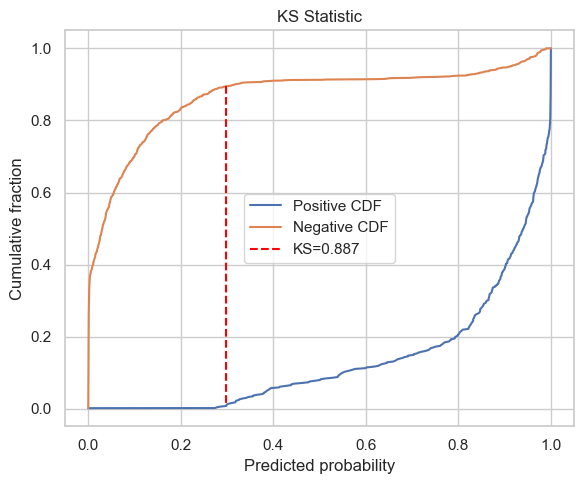

In [ ]:
# 13) KS Statistic plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure y_proba exists
if 'y_proba' not in globals():
    y_proba = model.predict_proba(X_test)[:, 1]

# Separate scores by class
pos_scores = y_proba[y_test == 1]
neg_scores = y_proba[y_test == 0]

# Empirical CDFs
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1) / len(xs)
    return xs, ys

xs_pos, ys_pos = ecdf(pos_scores)
xs_neg, ys_neg = ecdf(neg_scores)

# Interpolate to common x grid
xs = np.sort(np.unique(np.concatenate([xs_pos, xs_neg])))
ys_pos_interp = np.interp(xs, xs_pos, ys_pos)
ys_neg_interp = np.interp(xs, xs_neg, ys_neg)
ks_stat = np.max(np.abs(ys_pos_interp - ys_neg_interp))
ks_x = xs[np.argmax(np.abs(ys_pos_interp - ys_neg_interp))]

plt.figure(figsize=(6,5))
plt.plot(xs, ys_pos_interp, label='Positive CDF')
plt.plot(xs, ys_neg_interp, label='Negative CDF')
plt.vlines(ks_x, ys_neg_interp[np.argmax(np.abs(ys_pos_interp - ys_neg_interp))], ys_pos_interp[np.argmax(np.abs(ys_pos_interp - ys_neg_interp))], colors='red', linestyles='--', label=f'KS={ks_stat:.3f}')
plt.xlabel('Predicted probability')
plt.ylabel('Cumulative fraction')
plt.title('KS Statistic')
plt.legend()
plt.tight_layout()
plt.show()

c:\Users\bhara\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\bhara\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\bhara\AppData\Local\Pro

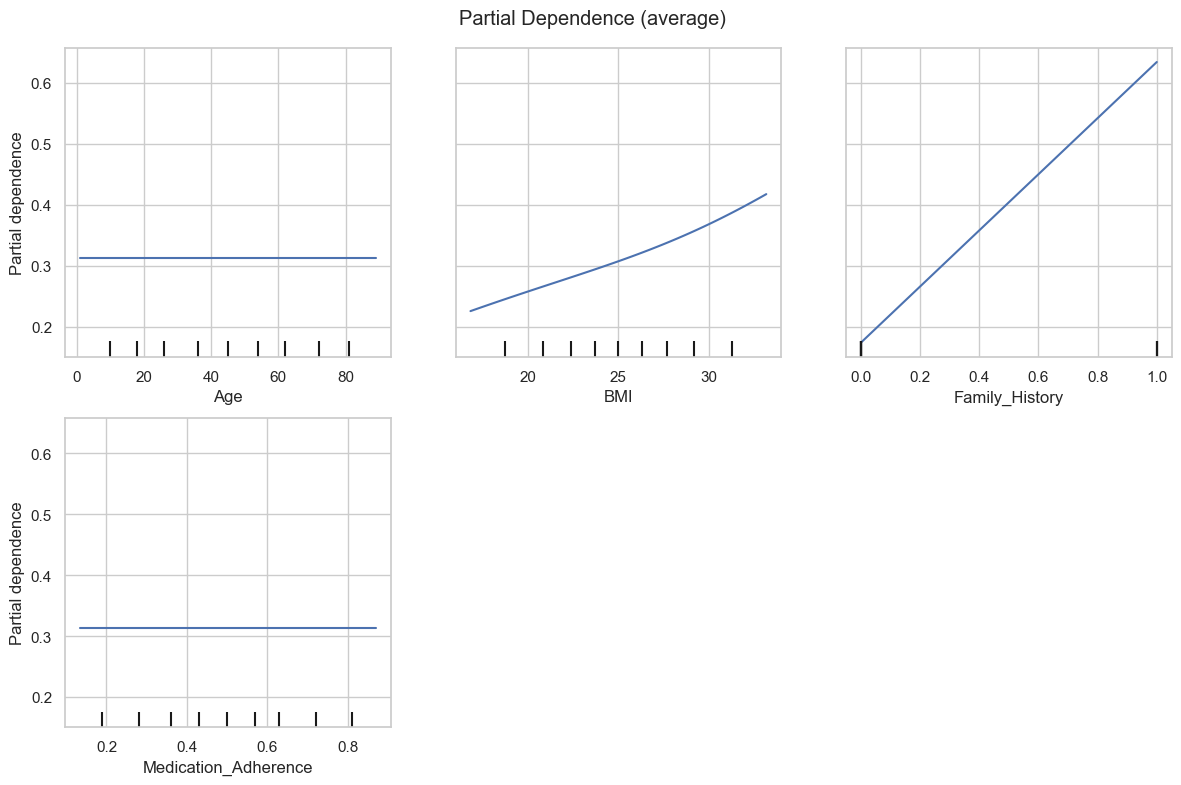

In [ ]:
# 14) Partial Dependence Plots (PDP) for numeric features
# Pick a few numeric features if available
num_for_pdp = [c for c in num_cols if c in X_train.columns][:4]
if len(num_for_pdp) == 0:
    print('No numeric features available for PDP')
else:
    fig, ax = plt.subplots(figsize=(12, 8))
    try:
        PartialDependenceDisplay.from_estimator(model, X_train, features=num_for_pdp, kind='average', ax=ax)
        plt.suptitle('Partial Dependence (average)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('PDP failed:', e)